# AUTOENCODER
This file have purpose to anlysys performance of autoencoder model

reference : https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
## Prepare Program and Data

In [1]:
# Import library create by mysel
from directory_handle import DirectoryHandle
import image_handle as ImageHandle
import data_handle as DataHandle

# Import library for plot image
import matplotlib.pyplot as plt

# Import library for manage model part Core Layers
from keras.layers import Input, Flatten, Dense, Reshape
# Import library for manage model part Convolution Layers
from keras.layers import Conv2D, Conv2DTranspose
# Import Library for manage model part Model Object
from keras.models import Model
# Import Library for manage model part optimizer
from keras.optimizers import Adam
# Import Library about model 
from keras.utils import plot_model
# Import library for load model
from keras.models import load_model

#Import library for normal process
import numpy as np

Using TensorFlow backend.


In [4]:
# Constant data path to collect directory data
PATH_DATA = "/home/zeabus/Documents/supasan/2019_deep_learning/PokemonData" 

# Part parameter in normal program will require to input
crop = True
color = True
rounds = 10 # Round to train data (epoches)

In [5]:
# Process Read data 
directory_handle = DirectoryHandle( PATH_DATA )
list_label , list_data = directory_handle.group_data()

smallest_size = ImageHandle.min_all_square_size1( list_data )
smallest_size = smallest_size if smallest_size % 2 == 0 else smallest_size - 1
latent_size = int( smallest_size * smallest_size / 4 )
latent_size = latent_size * 3 if color else latent_size
print(f'Will manage by resize image to smallest size {smallest_size} square and have latent size {latent_size}')

input_dim = ( smallest_size , smallest_size , 3 if color else 1 )

X_data , Y_data = ImageHandle.prepare_label_data( list_label , list_data , smallest_size , color = color , crop = crop )

Will manage by resize image to smallest size 42 square and have latent size 1323


## Model Part
Above part is part prepare data for train test and analysis

In [4]:
# Set up model part encoder
encoder_input = Input( shape = input_dim , name = 'encode_input' )
encoder = encoder_input
encoder = Conv2D( filters = 64,
                kernel_size = (3,3),
                strides=2,
                padding='same',
                activation='relu',
                name = "encoder_convolution_1")(encoder)
encoder = Conv2D( filters = 32,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_2")(encoder)
encoder = Conv2D( filters = 16,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_3")(encoder)
shape_before_flatten = (int(smallest_size/2) , int(smallest_size/2) , 16)
encoder = Flatten()(encoder)
encoder_output = Dense( latent_size , name = "encoder_output")(encoder)

encoder_model = Model( encoder_input , encoder_output )
encoder_model.name = "encoder_model"
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
Total params: 9,361,291
Trainable params: 9,361,291
Non-trainable params: 0
___________________________________________

In [5]:
decoder_input = Input( shape = (latent_size,) , name ='decoder_input')
decoder = Dense( np.prod(shape_before_flatten) , name='decoder_input_convolution' )(decoder_input)
decoder = Reshape( shape_before_flatten , name='decoder_input_reshape')(decoder)
decoder = Conv2DTranspose( filters = 32,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_convolution_1',
                        activation='relu')(decoder)
decoder = Conv2DTranspose( filters = 64,
                        kernel_size = (3,3),
                        strides=2,
                        padding='same',
                        name='decoder_convolution_2',
                        activation='relu')(decoder)
decoder_output = Conv2DTranspose( filters = 3 if color else 1,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_output',
                        activation='relu')(decoder)
decoder_model = Model( decoder_input , decoder_output )
decoder_model.name = "decoder_model"
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 1323)              0         
_________________________________________________________________
decoder_input_convolution (D (None, 7056)              9342144   
_________________________________________________________________
decoder_input_reshape (Resha (None, 21, 21, 16)        0         
_________________________________________________________________
decoder_convolution_1 (Conv2 (None, 21, 21, 32)        4640      
_________________________________________________________________
decoder_convolution_2 (Conv2 (None, 42, 42, 64)        18496     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 42, 42, 3)         1731      
Total params: 9,367,011
Trainable params: 9,367,011
Non-trainable params: 0
___________________________________________

In [6]:
autoencoder = Model( encoder_input , decoder_model(encoder_output) )
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
_________________________________________________________________
decoder_model (Model)        (None, 42, 42, 3)         9367

## Train Model

In [9]:
# Before train data first time must split data for train and test
(X_train,Y_train) , (X_test,Y_test) = DataHandle.train_test_split( X_data , Y_data , 8 )
print(f'From {len(X_data)} datas split for train {len(X_train)} and test {len(X_test)}')

From 6781 datas split for train 5934 and test 847


In [8]:
optimizer = Adam( lr = 0.0005 ) # set learning
autoencoder.compile( optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit( [X_train], # Input
                          [X_train], # Output
                         validation_data=( [X_test] , [X_test]),
                         epochs = rounds )

Train on 5934 samples, validate on 847 samples
Epoch 1/10
5934/5934 [==============================] - 100s 17ms/step - loss: 4453.5844 - accuracy: 0.4413 - val_loss: 2680.7589 - val_accuracy: 0.6002
Epoch 2/10
5934/5934 [==============================] - 104s 18ms/step - loss: 2291.7796 - accuracy: 0.5940 - val_loss: 1989.8142 - val_accuracy: 0.6165
Epoch 3/10
5934/5934 [==============================] - 104s 18ms/step - loss: 1825.8953 - accuracy: 0.6306 - val_loss: 1846.7085 - val_accuracy: 0.6545
Epoch 4/10
5934/5934 [==============================] - 101s 17ms/step - loss: 1592.7611 - accuracy: 0.6563 - val_loss: 1538.8796 - val_accuracy: 0.6900
Epoch 5/10
5934/5934 [==============================] - 96s 16ms/step - loss: 1428.5227 - accuracy: 0.6755 - val_loss: 1372.6685 - val_accuracy: 0.7178
Epoch 6/10
5934/5934 [==============================] - 95s 16ms/step - loss: 1272.6402 - accuracy: 0.6962 - val_loss: 1301.7343 - val_accuracy: 0.7272
Epoch 7/10
5934/5934 [===============

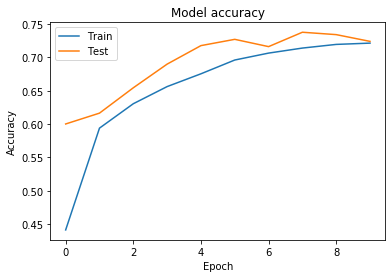

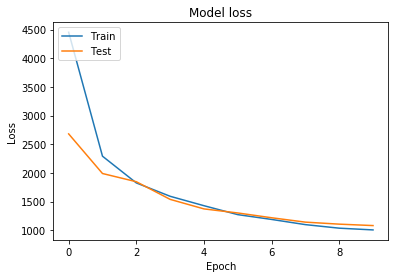

In [9]:
# Plot traing & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
autoencoder.save( "pokemon_autoencoder.h5")

## Result Model

In [19]:
random_index = []
for _ in range(0,10):
    random_index.append( np.random.randint( len( X_test)))
random_index = tuple( set( random_index ) )
data = []
for index in random_index :
    data.append( X_test[ index ] )
data = np.array( data )

In [15]:
autoencoder = load_model( "pokemon_autoencoder.h5" )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


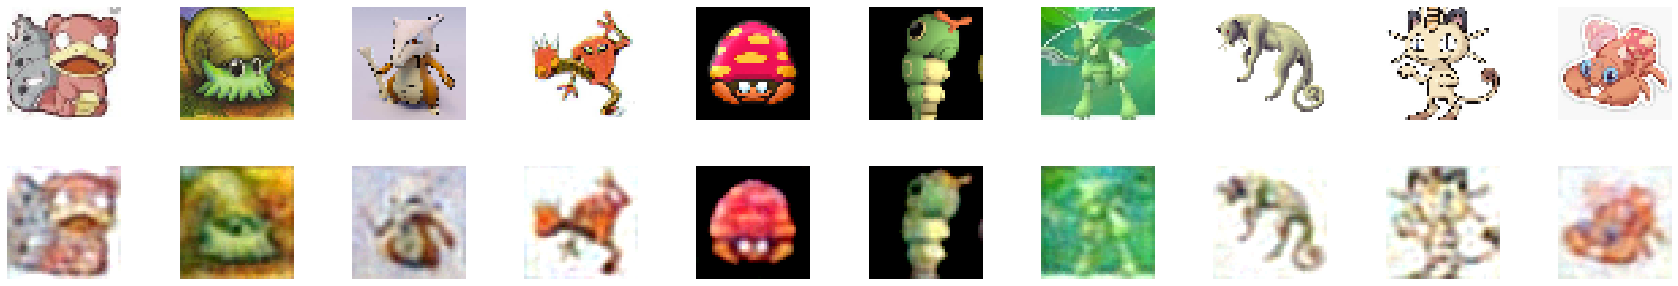

In [20]:
DataHandle.plot_compare( data , autoencoder , (30,5))